In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.stats import ks_2samp
from sklearn.datasets import make_classification

In [2]:
from main import *

### Elliptical Slice Sampling

- Target : $\pi = \mathcal{N}(\frac{1}{3}, \frac{2}{3})$
- Prior : $\mu_0 = \mathcal{N}(0, 1)$
- likelihood : $\rho(x) \propto \mathcal{N}(x; 1, 2)$


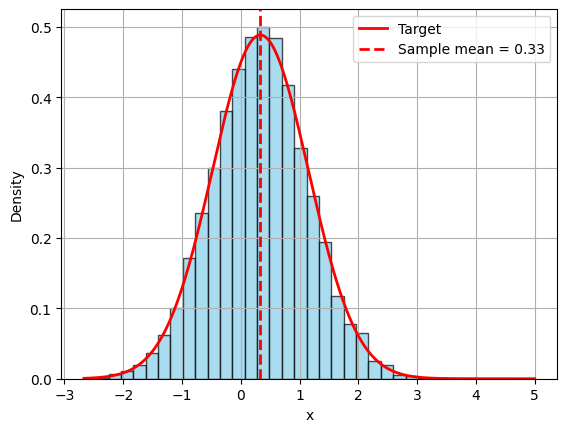

In [3]:
if __name__ == "__main__":
    d = 1  # Dimension
    m = np.ones(d)
    v = 2*np.eye(d)

    x_init = np.array([5])
    N = 10000

    ess_sample = np.array(elliptical_slice_sampling(x_init, m, v, N))
    # Histogramme avec densité (area under histogram = 1)
    plt.hist(ess_sample[1000:], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Ligne de densité normale théorique
    l = np.linspace(min(ess_sample), max(ess_sample), N)
    plt.plot(l, norm.pdf(l, 1/3, np.sqrt(2/3)), 'r-', lw=2, label='Target')

    mean_value = np.mean(ess_sample) 
    # Afficher
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Sample mean = {mean_value:.2f}')

# Ajouter titre et légende
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.savefig("images/ess_gaussian_target.png", dpi=300, bbox_inches='tight')
    plt.show()

Effective Sample Size (ESS): 4375.09 / 10000


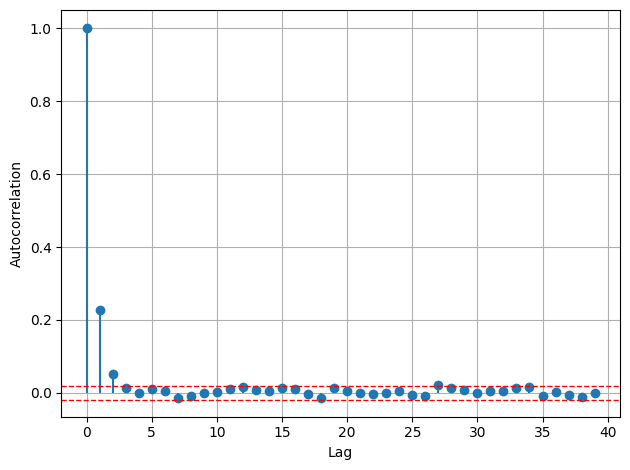

In [4]:
def compute_ess(sample, max_lag=100):
    n = len(sample)
    acf_vals = acf(sample, nlags=max_lag, fft=True)
    # Sum autocorrelations until they become negative
    positive_acf = acf_vals[1:]
    s = 1 + 2 * np.sum(positive_acf[positive_acf > 0])
    ess = n / s
    return ess, acf_vals

if __name__ == "__main__":

    # Compute ESS
    ess, acf_vals = compute_ess(ess_sample, max_lag=100)
    print(f"Effective Sample Size (ESS): {ess:.2f} / {N}")
    conf_interval = 1.96 / np.sqrt(N)
    # Plot ACF
    plt.stem(acf_vals[:40], basefmt=" ")
    plt.axhline(y=conf_interval, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=-conf_interval, color='red', linestyle='--', linewidth=1)
    #plt.title("Autocorrelation Function (ACF)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("images/acf_ess_gaussian_target.png", dpi=300)
    plt.show()

In [5]:
def log_volcano(x):
    return np.sqrt(np.sum(x**2))

def volcano_transition(x):
    w = np.random.randn(2)
    log_t = np.log(np.random.uniform(0, 1)) + log_volcano(x)

    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    proposal = x * np.cos(theta) + w * np.sin(theta)
    while log_volcano(proposal) < log_t:
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal = x * np.cos(theta) + w * np.sin(theta)
    return proposal


def ess_volcano(x_init, N):
    sample = [x_init]
    x = x_init
    for _ in range(N):
        x = volcano_transition(x)
        sample.append(x)
    return sample

if __name__ == "__main__":
    x_init =  np.random.randn(2)
    N = 10000

    volcano_sample = ess_volcano(x_init, N)

    

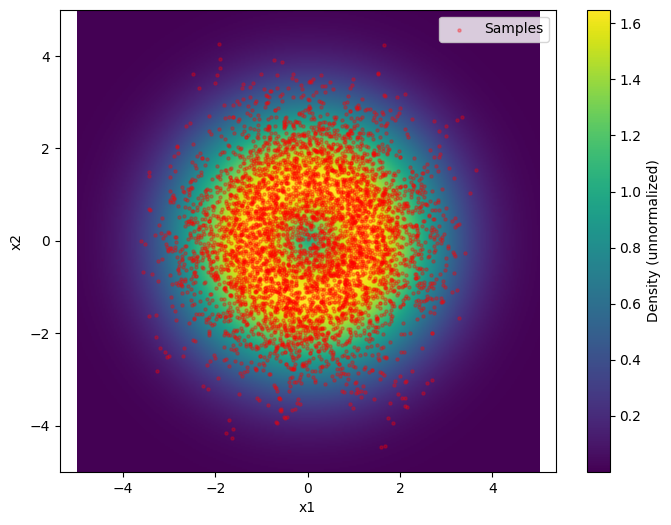

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def log_volcano(x):
    return np.linalg.norm(x)

def volcano_transition(x):
    w = np.random.randn(2)
    log_t = np.log(np.random.uniform(0, 1)) + log_volcano(x)

    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    proposal = x * np.cos(theta) + w * np.sin(theta)
    while log_volcano(proposal) < log_t:
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal = x * np.cos(theta) + w * np.sin(theta)
    return proposal


def ess_volcano(x_init, N):
    sample = [x_init]
    x = x_init
    for _ in range(N):
        x = volcano_transition(x)
        sample.append(x)
    return np.array(sample)


if __name__ == "__main__":
    x_init = np.random.randn(2)
    N = 5000

    volcano_sample = ess_volcano(x_init, N)

    # ==== Grille pour la heatmap ====
    x = np.linspace(-4, 4, 300)
    y = np.linspace(-4, 4, 300)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(np.sqrt(X**2 + Y**2) - 0.5 * (X**2 + Y**2))  # densité non normalisée

    # ==== Heatmap ====
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=[-5, 5, -5, 5], origin="lower", 
               cmap="viridis", aspect="auto")
    plt.colorbar(label="Density (unnormalized)")
    
    # ==== Points échantillonnés ====
    plt.scatter(volcano_sample[:,0], volcano_sample[:,1], 
                s=5, alpha=0.3, color="red", label="Samples")

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.axis("equal")
    #plt.tight_layout()
    plt.savefig("images/volcano.png", dpi=300, bbox_inches='tight')
    plt.show()


### Common random number coupling

- One while loop to select always de the same $\theta$

In [7]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2


def coupled_transition(x, y, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    log_p_x, log_p_y = log_likelihood(x, m, v), log_likelihood(y, m, v)
    u = np.log(np.random.uniform(0, 1))
    log_tx = log_p_x + u
    log_ty = log_p_y + u

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x, proposal_y = x * np.cos(theta) + w * np.sin(theta),  y * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x, log_p_proposal_y = log_likelihood(proposal_x, m, v), log_likelihood(proposal_y, m, v)

    while log_p_proposal_x < log_tx and log_p_proposal_y < log_ty :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal_x, proposal_y = x * np.cos(theta) + w * np.sin(theta),  y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x, log_p_proposal_y = log_likelihood(proposal_x, m, v), log_likelihood(proposal_y, m, v)

    return proposal_x, proposal_y, theta, w


def coupled_ess(x_init, y_init, m, v, N):
    coupled_chain = [(x_init, y_init)]
    x, y = x_init, y_init
    list_theta = []
    list_w = []
    for i in range(N):
        x, y, theta, w = coupled_transition(x, y, m, v)
        list_theta.append(theta)
        list_w.append(w)
        coupled_chain.append((x, y))

    return coupled_chain, list_theta, list_w

In [8]:
if __name__ == "__main__":
    m, v = 1, 2

    x_init, y_init = 5, -3
    N = 10000

    coupled_chain, list_theta, list_w = coupled_ess(x_init, y_init, m, v, N)

In [9]:
x_sample = np.array([coupled_chain[i][0] for i in range(len(coupled_chain))])
y_sample = np.array([coupled_chain[i][1] for i in range(len(coupled_chain))])
meet_time = []
for i in range(len(coupled_chain)):
    if x_sample[i] == y_sample[i]:
        meet_time.append(i)
n = meet_time[0]
np.cos(list_theta[n-1])

np.float64(0.2550928499449764)

- The coupling seems to be successful meaning that they coincide forever after a finite certain time, but it is false we show easily that if $x_n \neq y_n$ then $x_{n+1} \neq y_{n+1}$ a.s.
proof : suppose $x_n \neq y_n$ and $x_{n+1} = y_{n+1}$ over $A$ s.t $P(A) > 0$ then we have $cos(\theta_{n+1}) = 0$ over A however 
    - $P(cos(\theta_{n+1}) = 0) = 0$
- If the chains seem to coincide is a numerical rounding problem in fact the cos has to be null so that the chains meet but it is not the case see above it's a bit disturbing and awkward.

- $\texttt{x}$ sample density compared to the target 

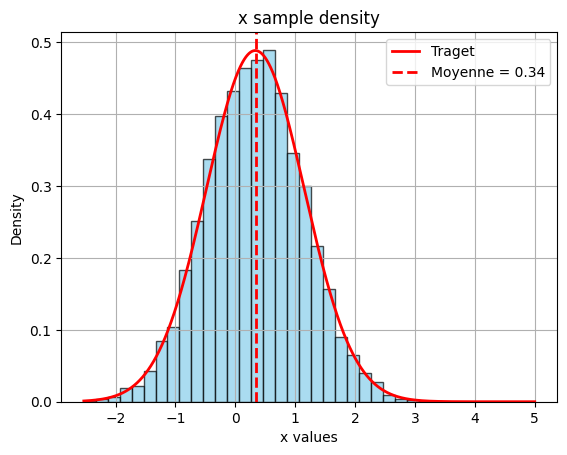

In [10]:
# Histogramme avec densité (area under histogram = 1)
plt.hist(x_sample[1000:], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Ligne de densité normale théorique
l = np.linspace(min(x_sample), max(x_sample), N)
plt.plot(l, norm.pdf(l, 1/3, np.sqrt(2/3)), 'r-', lw=2, label='Traget')

mean_value = np.mean(x_sample) 
    # Afficher
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne = {mean_value:.2f}')

plt.title('x sample density')
plt.xlabel('x values')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

- ACF of $\texttt{x}$ sample

<function matplotlib.pyplot.show(close=None, block=None)>

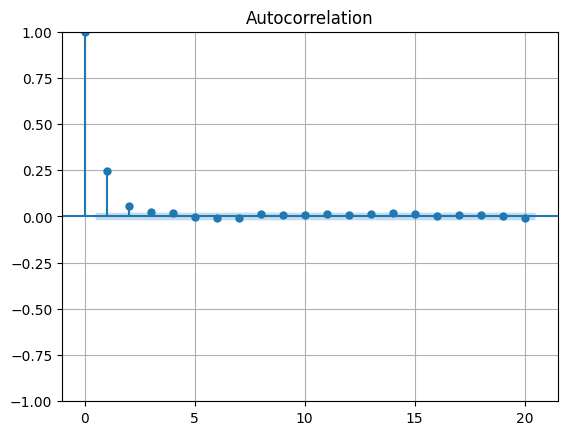

In [11]:
plot_acf(x_sample, lags= 20)
plt.grid()
plt.show

- Now one need to check that the one loop coupling conserves the ESS transition we compare $\texttt{x\_sample}$ and $\texttt{x\_sample}$ with a simple ESS sample 
- We do a Kolmogorov Smirnov test 

In [12]:
if __name__ == "__main__":

    m = np.ones(1)
    v = 2*np.eye(1)
    x_init = np.array([5])
    y_init = np.array([-5])
    N = 10000

    ess_distrib = np.array([transition(y_init, m, v) for _ in range(N)]).reshape(-1)
    coupled_marginal = np.array([coupled_transition(x_init, y_init, m, v)[1] for _ in range(N)]).reshape(-1)
    statistic, p_value = ks_2samp(ess_distrib, coupled_marginal)

    print(f"Statistique KS : {statistic:.4f}")
    print(f"p-value : {p_value:.4f}")

Statistique KS : 0.0180
p-value : 0.0783


- for $\texttt{y}$ sample the test does not reject $H_0$ systematically however for $\texttt{x}$ sample it does.

- See if $\texttt{x}$ and $\texttt{y}$ contracts  

C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\3416309601.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(x_sample - y_sample)))


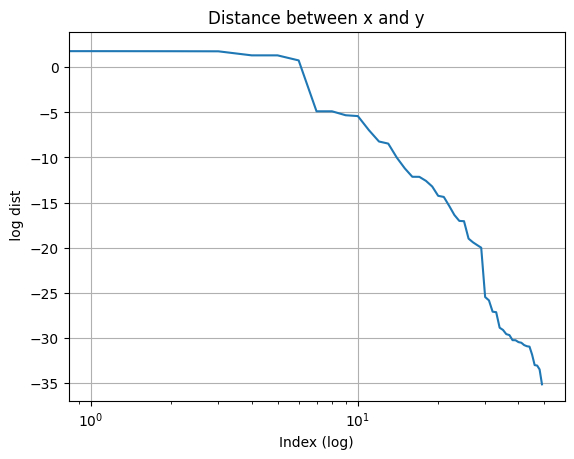

In [13]:
plt.plot(np.log(np.abs(x_sample - y_sample)))
plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
plt.title("Distance between x and y")
plt.xlabel("Index (log)")
plt.ylabel(" log dist")
plt.grid()
plt.show()

- the two chains seems to contract how every to show it theoretically does not make us move forward since the it does not seem obvious that the marginals transitions are form ESS. 

- Two while loops to have different decisions meaning possibly different $\theta$

In [14]:
def coupled_transition2(x, y, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    log_px, log_py = log_likelihood(x, m, v), log_likelihood(y, m, v)
    u_slice = np.log(np.random.uniform(0, 1))
    log_tx = log_px + u_slice
    log_ty = log_py + u_slice

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x = log_likelihood(proposal_x, m, v)

    theta_visited = [theta]
    while log_p_proposal_x < log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood(proposal_x, m, v)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_p_proposal_y = log_likelihood(proposal_y, m, v)

    counter = 1
    while log_p_proposal_y < log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
            counter += 1
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood(proposal_y, m, v) 

    return proposal_x, proposal_y, theta_visited[-1], theta


def coupled_ess2(x_init, y_init, m, v, N):
    samples = [(x_init, y_init)]
    x, y = samples[0]
    list_theta2 = []

    for _ in tqdm(range(N)):
        x, y, theta1, theta2 = coupled_transition2(x, y, m, v)
        list_theta2.append((theta1, theta2))
        samples.append((x, y))

    return samples, list_theta2

In [15]:
if __name__ == "__main__":
    m = 1
    v = 2
    x_init = 20
    y_init = -10
    N = 100000

    samples, list_theta2 = coupled_ess2(x_init, y_init, m, v, N)
    x_sample2 = np.array([samples[i][0] for i in range(len(samples))])
    y_sample2 = np.array([samples[i][1] for i in range(len(samples))])

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:01<00:00, 58558.29it/s]


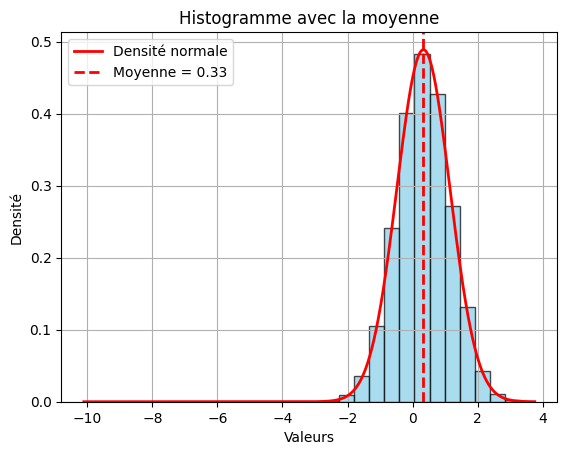

In [16]:
plt.hist(y_sample2, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Ligne de densité normale théorique
l = np.linspace(min(y_sample2), max(y_sample2), N)
plt.plot(l, norm.pdf(l, 1/3, np.sqrt(2/3)), 'r-', lw=2, label='Densité normale')

mean_value = np.mean(y_sample2) 
# Afficher
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne = {mean_value:.2f}')

# Ajouter titre et légende
plt.title("Histogramme avec la moyenne")
plt.xlabel("Valeurs")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\2154661780.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(x_sample2 - y_sample2)))


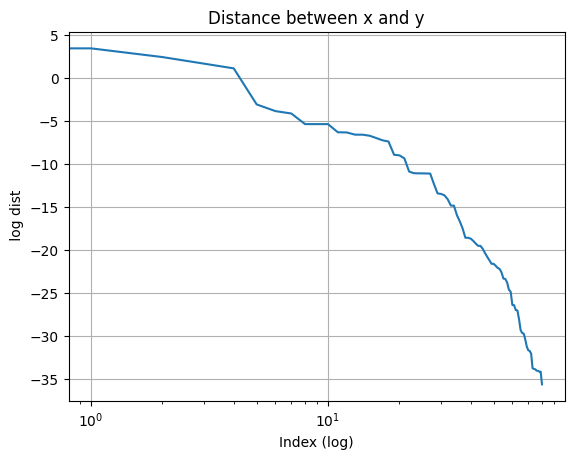

In [17]:
plt.plot(np.log(np.abs(x_sample2 - y_sample2)))
plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
plt.title("Distance between x and y")
plt.xlabel("Index (log)")
plt.ylabel(" log dist")
plt.grid()
plt.show()

In [18]:
def indicator(x, m):
    return int(x <= m and x >= 0)/m

def max_cpl(m_, m):
    x = np.random.uniform(0, m_)
    w = np.random.uniform(0, 1)

    if w * indicator(x, m_) <= indicator(x, m):
        return x, x
    
    y = np.random.uniform(0, m)
    w = np.random.uniform(0, 1)
    while indicator(y, m_) > w * indicator(y, m):
        y = np.random.uniform(0, m)
        w = np.random.uniform(0, 1)
    return x, y

def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2

In [19]:
def coupled_transition2_max(x, y, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    px, py = np.exp(log_likelihood(x, m, v)), np.exp(log_likelihood(y, m, v))
    cpl = max_cpl(px, py)
    log_tx, log_ty = np.log(cpl[0]), np.log(cpl[1])

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x = log_likelihood(proposal_x, m, v)

    theta_visited = [theta]
    while log_p_proposal_x < log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood(proposal_x, m, v)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_p_proposal_y = log_likelihood(proposal_y, m, v)

    counter = 1
    while log_p_proposal_y < log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
            counter += 1
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood(proposal_y, m, v) 

    return proposal_x, proposal_y, (log_tx, log_ty)


def coupled_ess2_max(x_init, y_init, m, v, N):
    samples = [(x_init, y_init)]
    x, y = samples[0]
    T = []
    for _ in tqdm(range(N)):
        x, y, t = coupled_transition2_max(x, y, m, v)
        T.append(t)
        samples.append((x, y))

    return samples, T

In [20]:
if __name__ == "__main__":
    m = 1
    v = 2
    x_init = 20
    y_init = -10
    N = 100000

    samples, T = coupled_ess2_max(x_init, y_init, m, v, N)
    xx = np.array([samples[i][0] for i in range(len(samples))])
    yy = np.array([samples[i][1] for i in range(len(samples))])

100%|██████████| 100000/100000 [00:02<00:00, 40943.41it/s]


C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\878856124.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(xx - yy))[:1000], label = "CRN coupling with Maximal coupling ")
C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\878856124.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(x_sample2 - y_sample2))[:1000], label = "CRN coupling")


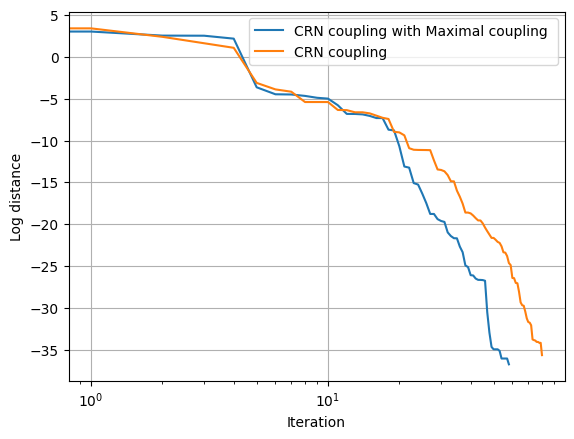

In [21]:
plt.plot(np.log(np.abs(xx - yy))[:1000], label = "CRN coupling with Maximal coupling ")
plt.plot(np.log(np.abs(x_sample2 - y_sample2))[:1000], label = "CRN coupling")
plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
plt.xlabel("Iteration")
plt.ylabel("Log distance")
plt.legend()
plt.grid()
plt.savefig("images/crn_max_ess.png", dpi=300, bbox_inches='tight')
plt.show()

### Bayesian Logistic Regression (density shifting) for the coupling 2

In [23]:
X, Y = make_classification(n_samples=1000, n_features=4, n_classes=2, random_state=0)
Y = 2 * Y - 1  # transforme les labels 0,1 en -1,1

print(X.shape)  # (1000, 20)
print(np.unique(Y), Y.shape[0])  # [-1  1]

def log_likelihood_blr(x, X, Y, e):
    z = Y * (X @ x)
    return -np.sum(np.log1p(np.exp(-z)))- (e/2) * np.sum(x**2) # log(1 + exp(-z)) * tail shift 



(1000, 4)
[-1  1] 1000


In [24]:
def coupled_transition2_blr(x, y, X, Y, e):
    d = X.shape[1]
    w = np.sqrt(1/(1-e))*np.random.randn(1, d).reshape(-1)  # w ~ N(0, I)

    log_px, log_py = log_likelihood_blr(x, X, Y, e), log_likelihood_blr(y, X, Y, e)
    u_slice = np.log(np.random.uniform(0, 1))
    log_tx = log_px + u_slice
    log_ty = log_py + u_slice

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x = log_likelihood_blr(proposal_x, X, Y, e)

    theta_visited = [theta]
    while log_p_proposal_x < log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood_blr(proposal_x, X, Y, e)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_p_proposal_y = log_likelihood_blr(proposal_y, X, Y, e)

    counter = 1
    while log_p_proposal_y < log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
            counter += 1
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood_blr(proposal_y, X, Y, e) 

    return proposal_x, proposal_y, theta_visited[-1], theta


def coupled_ess2_blr(x_init, y_init, X, Y, e, N):
    samples = [(x_init, y_init)]
    x, y = samples[0]
    list_theta2 = []

    for _ in tqdm(range(N)):
        x, y, theta1, theta2 = coupled_transition2_blr(x, y, X, Y, e)
        list_theta2.append((theta1, theta2))
        samples.append((x, y))

    return samples, list_theta2

100%|██████████| 10000/10000 [00:05<00:00, 1681.18it/s]


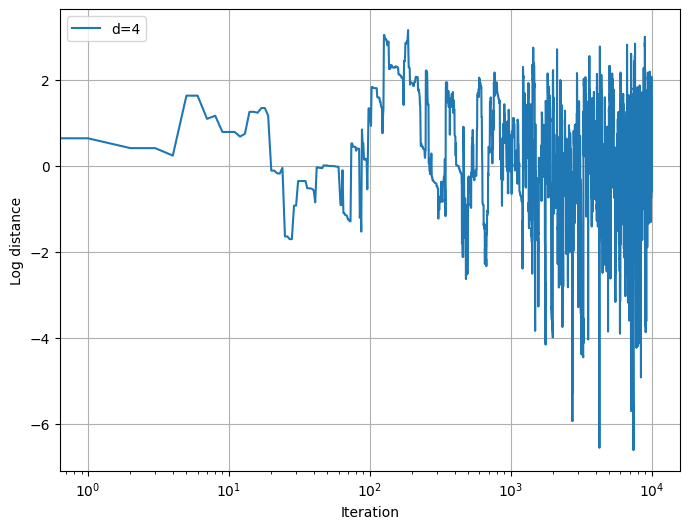

In [214]:
if __name__ == "__main__":
    N = 10000
    e = 0.8
    plt.figure(figsize=(8, 6))

    for d in [2**k for k in range(2,3)]:
        X, Y = make_classification(n_samples=1000, n_features=d, n_classes=2, random_state=0)
        Y = 2 * Y - 1  # transforme les labels 0,1 en -1,1
    
        x_init, y_init = np.random.randn(2, d)

        samples, list_theta2 = coupled_ess2_blr(x_init, y_init, X, Y, e, N)
        x_sample_blr = np.array([samples[i][0] for i in range(len(samples))])
        y_sample_blr = np.array([samples[i][1] for i in range(len(samples))])

        dist = np.sum((x_sample_blr - y_sample_blr) ** 2, axis=1)
        
        plt.plot(np.log(dist), label=f"d={d}")
    plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
    plt.xlabel("Iteration")
    plt.ylabel("Log distance")
    plt.grid()
    plt.legend()
    plt.savefig("images/reglog_crn.png", dpi=300, bbox_inches='tight')
    plt.show()

100%|██████████| 10000/10000 [00:23<00:00, 426.91it/s]


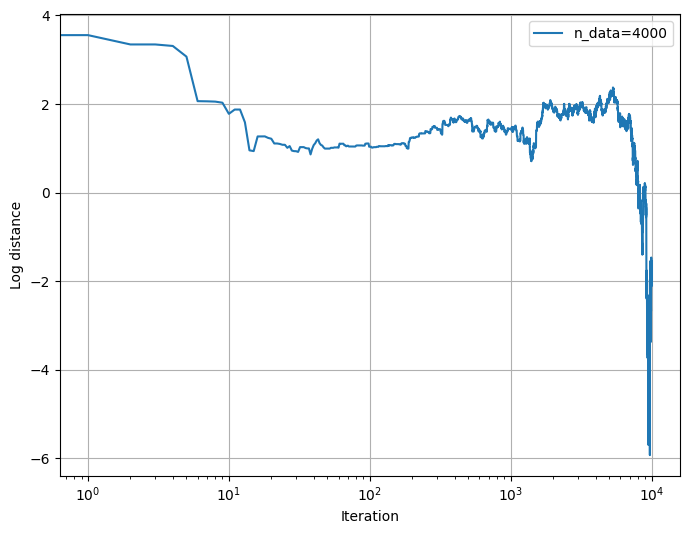

In [216]:
if __name__ == "__main__":
    N = 10000
    e = 0.8
    plt.figure(figsize=(8, 6))
    d = 8
    for n in range(4000, 4001):
        X, Y = make_classification(n_samples=n, n_features=d, n_classes=2, random_state=0, n_informative= 6)
        Y = 2 * Y - 1  # transforme les labels 0,1 en -1,1
    
        x_init, y_init = np.random.randn(2, d)

        samples, list_theta2 = coupled_ess2_blr(x_init, y_init, X, Y, e, N)
        x_sample_blr = np.array([samples[i][0] for i in range(len(samples))])
        y_sample_blr = np.array([samples[i][1] for i in range(len(samples))])

        dist = np.sum((x_sample_blr - y_sample_blr) ** 2, axis=1)
        
        plt.plot(np.log(dist), label=f"n_data={n}")
    plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
    plt.xlabel("Iteration")
    plt.ylabel("Log distance")
    plt.grid()
    plt.legend()
    plt.savefig("images/reglog_crn.png", dpi=300, bbox_inches='tight')
    plt.show()

In [67]:
8*8*8

512

### In the casse of a multivariate normal distribution

In [70]:
def log_likelihood_g(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    inv_v = np.linalg.inv(v)
    return -0.5 * diff.T @ inv_v @ diff

In [71]:
def coupled_transition2_g(x, y, m, v, C):
    d = len(x)
    w = np.random.multivariate_normal(mean=np.zeros(d), cov=C).reshape(-1)

    log_px, log_py = log_likelihood_g(x, m, v), log_likelihood_g(y, m, v)
    u_slice = np.log(np.random.uniform(0, 1))
    log_tx = log_px + u_slice
    log_ty = log_py + u_slice

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x = log_likelihood_g(proposal_x, m, v)

    theta_visited = [theta]
    while log_p_proposal_x < log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood_g(proposal_x, m, v)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_p_proposal_y = log_likelihood_g(proposal_y, m, v)

    counter = 1
    while log_p_proposal_y < log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
            counter += 1
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood_g(proposal_y, m, v)

    return proposal_x, proposal_y, theta_visited[-1], theta


def coupled_ess2_g(x_init, y_init, m, v, C, N):
    samples = [(x_init, y_init)]
    x, y = samples[0]
    list_theta2 = []

    for _ in tqdm(range(N)):
        x, y, theta1, theta2 = coupled_transition2_g(x, y, m, v, C)
        list_theta2.append((theta1, theta2))
        samples.append((x, y))

    return samples, list_theta2

In [72]:
if __name__ == "__main__":
    d = 18
    m = np.ones(d)
    v = 2*np.eye(d)
    x_init, y_init = np.random.randn(2, d)
    N = 10000
    C = 7*np.eye(d)

    samples, list_theta_g = coupled_ess2_g(x_init, y_init, m, v, C, N)
    x_sample_g= np.array([samples[i][0] for i in range(len(samples))])
    y_sample_g = np.array([samples[i][1] for i in range(len(samples))])

100%|██████████| 10000/10000 [00:04<00:00, 2328.49it/s]


C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\185619047.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.sum(((x_sample_g - y_sample_g)[:])**2, axis=1)))


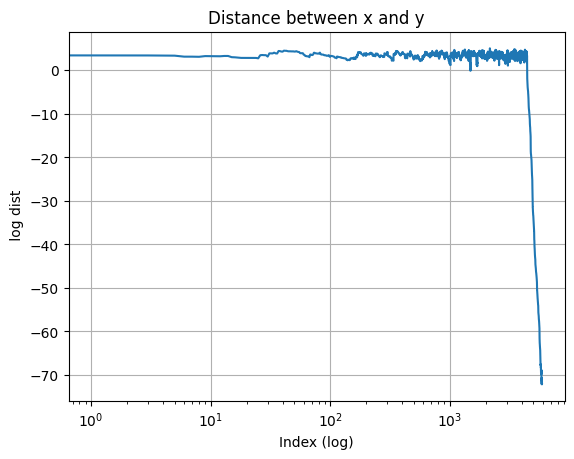

In [73]:
plt.plot(np.log(np.sum(((x_sample_g - y_sample_g)[:])**2, axis=1)))
plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
plt.title("Distance between x and y")
plt.xlabel("Index (log)")
plt.ylabel(" log dist")
plt.grid()
plt.show()

100%|██████████| 10000/10000 [00:01<00:00, 5946.03it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\947728246.py:22: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(dist), label=f"d={d}")
100%|██████████| 10000/10000 [00:29<00:00, 339.00it/s]


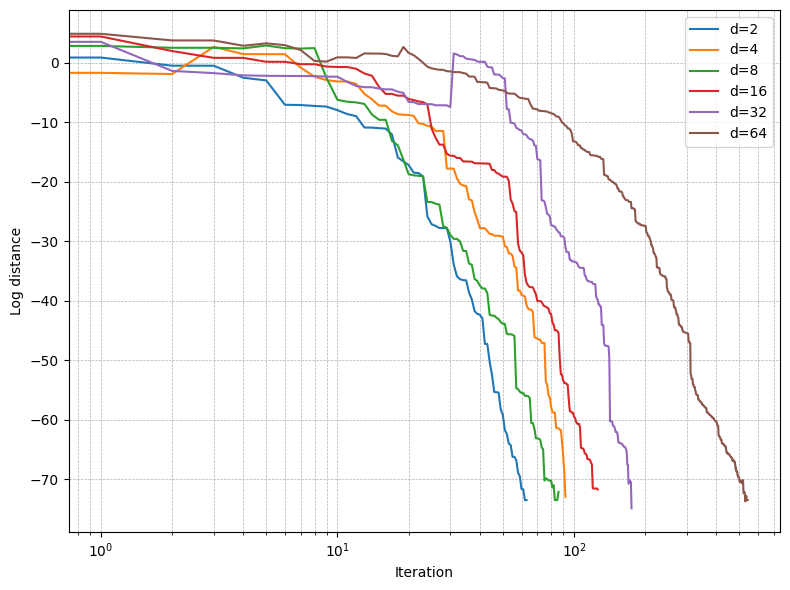

In [76]:
# === Ton code suppose que coupled_ess2_g est défini ailleurs ===

if __name__ == "__main__":
    N = 10000
    C = None  # sera défini pour chaque d
    
    
    plt.figure(figsize=(8, 6))
    
    for d in [2**k for k in range(1, 7)]:  # d = 2, 4, ...,
        m = np.ones(d)
        v = 2 * np.eye(d)
        x_init, y_init = np.random.randn(2, d)
        C =  np.eye(d)
        samples, list_theta_g = coupled_ess2_g(x_init, y_init, m, v, C, N)

        x_sample_g = np.array([samples[i][0] for i in range(len(samples))])
        y_sample_g = np.array([samples[i][1] for i in range(len(samples))])

        dist = np.sum((x_sample_g - y_sample_g) ** 2, axis=1)
        
        plt.plot(np.log(dist), label=f"d={d}")

    plt.xscale("log")  # axe X en log
    plt.xlabel("Iteration")
    plt.ylabel("Log distance")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig("images/crn_ess_g.png", dpi=300, bbox_inches='tight')
    plt.show()

100%|██████████| 10000/10000 [00:02<00:00, 4390.89it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_15524\2552904549.py:20: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(dist), label=f"c={c}")
100%|██████████| 10000/10000 [00:02<00:00, 3479.55it/s]


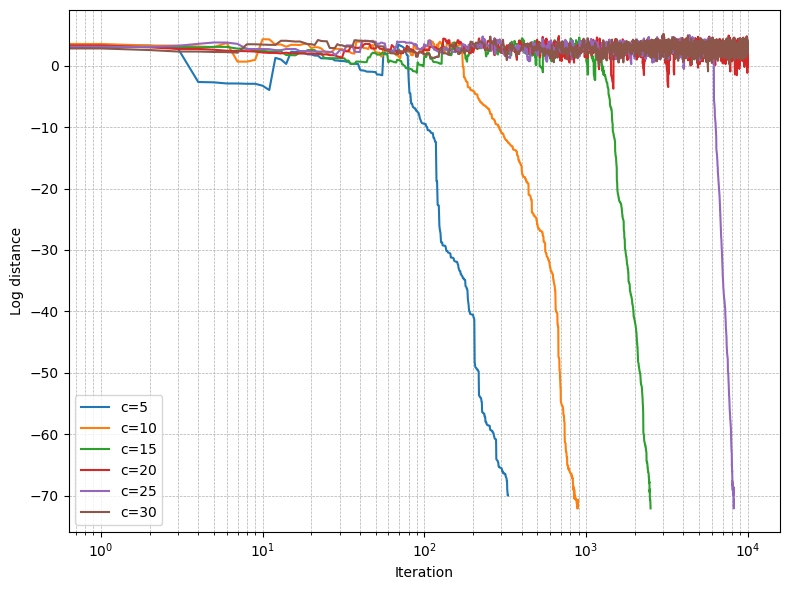

In [38]:

if __name__ == "__main__":
    N = 10000
    C = None  # sera défini pour chaque d
    d = 8
    m = np.ones(d)
    v = 2 * np.eye(d)
    x_init, y_init = np.random.randn(2, d)
    plt.figure(figsize=(8, 6))
    
    for c in range(5, 35, 5):  # d = 2, 4, ..., 18
        
        C =  c*np.eye(d)
        samples, list_theta_g = coupled_ess2_g(x_init, y_init, m, v, C, N)

        x_sample_g = np.array([samples[i][0] for i in range(len(samples))])
        y_sample_g = np.array([samples[i][1] for i in range(len(samples))])

        dist = np.sum((x_sample_g - y_sample_g) ** 2, axis=1)
        
        plt.plot(np.log(dist), label=f"c={c}")

    plt.xscale("log")  # axe X en log
    plt.xlabel("Iteration")
    plt.ylabel("Log distance")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig("images/crn_ess_gc.png", dpi=300, bbox_inches='tight')
    plt.show()


### Transition distribution

In [182]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2

def transition(x, m, v):
    """
    One step of Elliptical Slice Sampling (ESS)
    
    Parameters:
        x (np.ndarray): Current state
        m (np.ndarray): Mean of Gaussian target
        v (np.ndarray): Covariance of Gaussian target
        
    Returns:
        np.ndarray: New sample from the ESS transition
    """

    w = np.random.normal(0, 1)  # w ~ N(0, I)
    
    log_p_x = log_likelihood(x, m, v)
    log_y = log_p_x + np.log(np.random.uniform(0, 1))  # Slice threshold

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal = log_likelihood(proposal, m, v)

    # Shrinkage loop
    while log_p_proposal <= log_y:
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal = log_likelihood(proposal, m, v)

    return proposal

100%|██████████| 50000/50000 [00:01<00:00, 38698.41it/s]


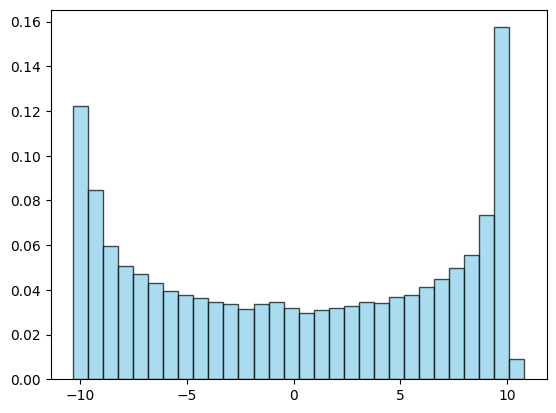

In [183]:
if __name__ == "__main__":
    m, v = 1, 2
    x = -10
    N = 50000
    
    sample = [transition(x, m, v) for _ in tqdm(range(N))]
    plt.hist(sample, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.show()

- it seems to be an innterpolation between a uniform and a Normal distribution 

### CRN Maximal coupling of ESS

- Gausssina case

In [77]:
def log_likelihood_g(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    inv_v = np.linalg.inv(v)
    return -0.5 * diff.T @ inv_v @ diff

In [78]:
def indicator(x, m):
    return int(x <= m and x >= 0)/m

def max_cpl(m_, m):
    x = np.random.uniform(0, m_)
    w = np.random.uniform(0, 1)

    if w * indicator(x, m_) <= indicator(x, m):
        return x, x
    
    y = np.random.uniform(0, m)
    w = np.random.uniform(0, 1)
    while indicator(y, m_) > w * indicator(y, m):
        y = np.random.uniform(0, m)
        w = np.random.uniform(0, 1)
    return x, y


In [79]:
def coupled_transition2_g_max(x, y, m, v, C):
    d = len(x)
    w = np.random.multivariate_normal(mean=np.zeros(d), cov=C).reshape(-1)

    px, py = np.exp(log_likelihood_g(x, m, v)), np.exp(log_likelihood_g(y, m, v))
    cpl = max_cpl(px, py)
    log_tx, log_ty = np.log(cpl[0]), np.log(cpl[1])

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x = log_likelihood_g(proposal_x, m, v)

    theta_visited = [theta]
    while log_p_proposal_x < log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood_g(proposal_x, m, v)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_p_proposal_y = log_likelihood_g(proposal_y, m, v)

    counter = 1
    while log_p_proposal_y < log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
            counter += 1
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood_g(proposal_y, m, v)

    return proposal_x, proposal_y


def coupled_ess2_g_max(x_init, y_init, m, v, C, N):
    samples = [(x_init, y_init)]
    x, y = samples[0]

    for _ in tqdm(range(N)):
        x, y = coupled_transition2_g_max(x, y, m, v, C)
        samples.append((x, y))

    return samples

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 5920.05it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\605013581.py:20: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(dist), label=f"d={d}")
100%|██████████| 10000/10000 [00:29<00:00, 336.95it/s]


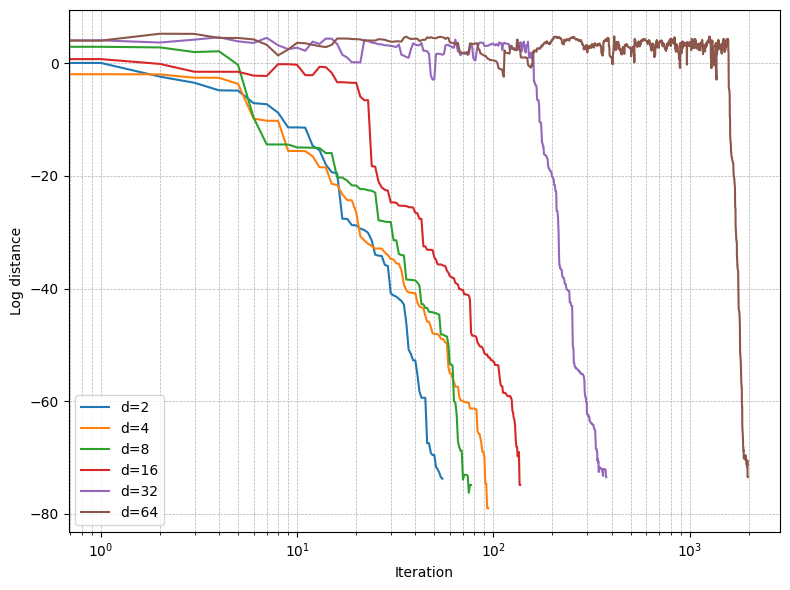

In [80]:
if __name__ == "__main__":
    N = 10000
    C = None  # sera défini pour chaque d
    
    
    plt.figure(figsize=(8, 6))
    
    for d in [2**k for k in range(1, 7)]:  # d = 2, 4, ...,
        m = np.ones(d)
        v = 2 * np.eye(d)
        x_init, y_init = np.random.randn(2, d)
        C =  np.eye(d)
        samples = coupled_ess2_g_max(x_init, y_init, m, v, C, N)

        x_sample_g = np.array([samples[i][0] for i in range(len(samples))])
        y_sample_g = np.array([samples[i][1] for i in range(len(samples))])

        dist = np.sum((x_sample_g - y_sample_g) ** 2, axis=1)
        
        plt.plot(np.log(dist), label=f"d={d}")

    plt.xscale("log")  # axe X en log
    plt.xlabel("Iteration")
    plt.ylabel("Log distance")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig("images/crn_max_ess_g.png", dpi=300, bbox_inches='tight')
    plt.show()

- Logistic regression case

In [81]:
def log_likelihood_blr(x, X, Y, e):
    z = Y * (X @ x)
    return -np.sum(np.log1p(np.exp(-z)))- (e/2) * np.sum(x**2) # log(1 + exp(-z)) * tail shift 


In [83]:
def coupled_transition2_blr_max(x, y, X, Y, e):
    d = X.shape[1]
    w = np.sqrt(1/(1-e))*np.random.randn(1, d).reshape(-1)  # w ~ N(0, I)

    px, py = np.exp(log_likelihood_blr(x, X, Y, e)), np.exp(log_likelihood_blr(y, X, Y, e))
    cpl = max_cpl(px, py)
    log_tx, log_ty = np.log(cpl[0]), np.log(cpl[1])

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x = log_likelihood_blr(proposal_x, X, Y, e)

    theta_visited = [theta]
    while log_p_proposal_x < log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood_blr(proposal_x, X, Y, e)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_p_proposal_y = log_likelihood_blr(proposal_y, X, Y, e)

    counter = 1
    while log_p_proposal_y < log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
            counter += 1
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood_blr(proposal_y, X, Y, e) 

    return proposal_x, proposal_y


def coupled_ess2_blr_max(x_init, y_init, X, Y, e, N):
    samples = [(x_init, y_init)]
    x, y = samples[0]

    for _ in tqdm(range(N)):
        x, y = coupled_transition2_blr_max(x, y, X, Y, e)
        samples.append((x, y))

    return samples

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\2482032373.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return int(x <= m and x >= 0)/m
C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\2359055042.py:7: RuntimeWarning: divide by zero encountered in log
  log_tx, log_ty = np.log(cpl[0]), np.log(cpl[1])
100%|██████████| 10000/10000 [00:02<00:00, 3552.30it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\3061408834.py:17: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(dist), label=f"d={d}")
100%|██████████| 10000/10000 [00:02<00:00, 3548.10it/s]


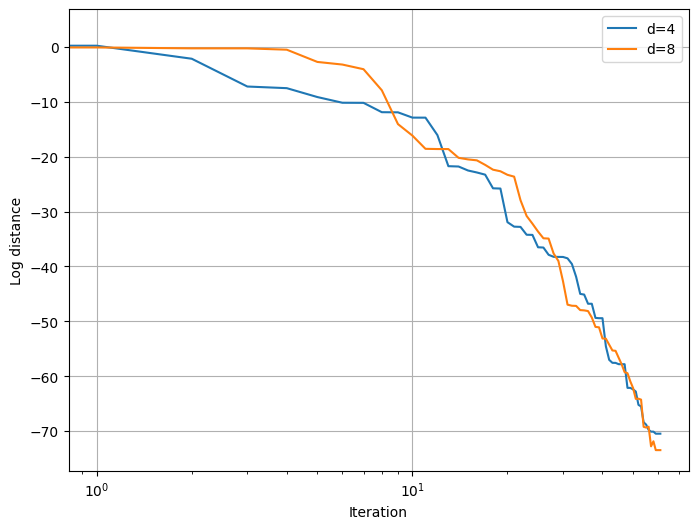

In [217]:
if __name__ == "__main__":
    N = 10000
    e = 0.8
    plt.figure(figsize=(8, 6))
    for d in [4, 8]:
        X, Y = make_classification(n_samples=3000, n_features=d, n_classes=2, random_state=0)
        Y = 2 * Y - 1  # transforme les labels 0,1 en -1,1
    
        x_init, y_init = np.random.randn(2, d)

        samples = coupled_ess2_blr_max(x_init, y_init, X, Y, e, N)
        x_sample_blr = np.array([samples[i][0] for i in range(len(samples))])
        y_sample_blr = np.array([samples[i][1] for i in range(len(samples))])

        dist = np.sum((x_sample_blr - y_sample_blr) ** 2, axis=1)
        
        plt.plot(np.log(dist), label=f"d={d}")
    plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
    plt.xlabel("Iteration")
    plt.ylabel("Log distance")
    plt.grid()
    plt.legend()
    plt.savefig("images/comp_informative_48.png", dpi=300, bbox_inches='tight')
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\2482032373.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return int(x <= m and x >= 0)/m
C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\2359055042.py:7: RuntimeWarning: divide by zero encountered in log
  log_tx, log_ty = np.log(cpl[0]), np.log(cpl[1])
100%|██████████| 10000/10000 [00:03<00:00, 3268.12it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_24860\3067463345.py:18: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(dist), label=f"Informative")


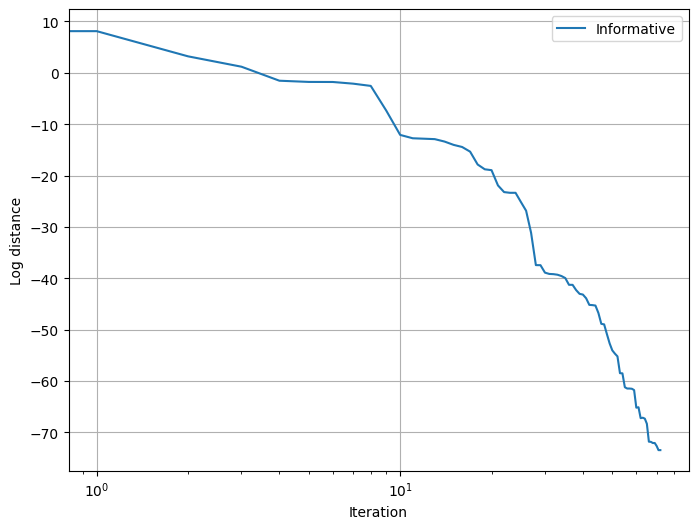

In [195]:
if __name__ == "__main__":
    N = 10000
    e = 0.8
    plt.figure(figsize=(8, 6))
    d = 2000
    
    X, Y = make_classification(n_samples=100, n_features=d, n_classes=2, random_state=0)
    Y = 2 * Y - 1  # transforme les labels 0,1 en -1,1

    x_init, y_init = np.random.randn(2, d)

    samples = coupled_ess2_blr_max(x_init, y_init, X, Y, e, N)
    x_sample_blr = np.array([samples[i][0] for i in range(len(samples))])
    y_sample_blr = np.array([samples[i][1] for i in range(len(samples))])

    dist = np.sum((x_sample_blr - y_sample_blr) ** 2, axis=1)
    
    plt.plot(np.log(dist), label=f"Informative")

    plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
    plt.xlabel("Iteration")
    plt.ylabel("Log distance")
    plt.grid()
    plt.legend()
    plt.savefig("images/comp_informative.png", dpi=300, bbox_inches='tight')
    plt.show()

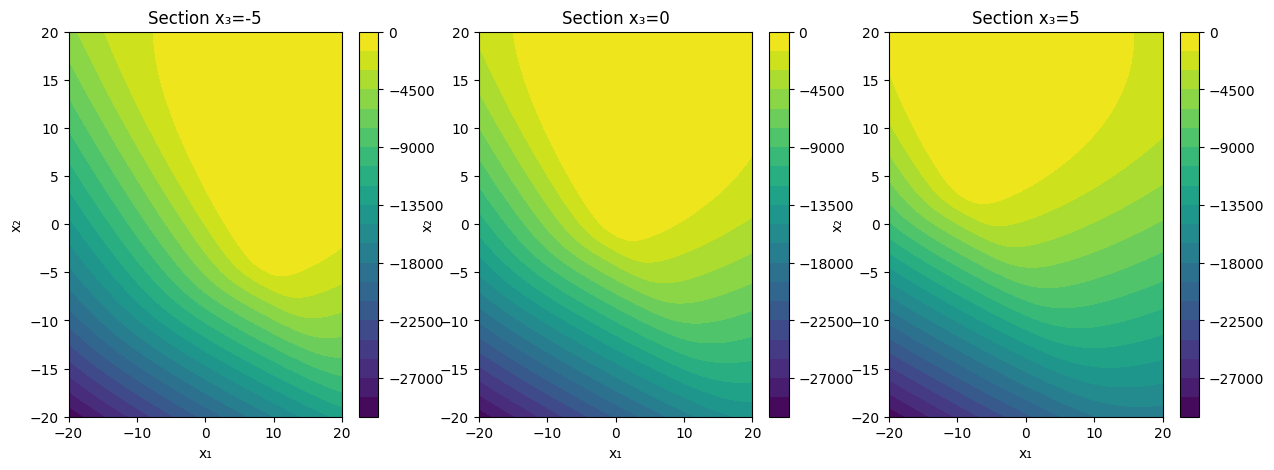

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# --- Génération de données en dimension 3 ---
X, Y = make_classification(
    n_samples=1000, n_features=3, n_classes=2,
    random_state=0, n_informative=2, n_redundant=1, n_clusters_per_class=1
)
Y = 2 * Y - 1  # transforme 0/1 en -1/1


# --- Définition de la log-vraisemblance BLR ---
def log_likelihood_blr(x, X, Y, e):
    z = Y * (X @ x)
    return -np.sum(np.log1p(np.exp(-z))) - (e/2) * np.sum(x**2)

# --- Grille 3D ---
grid = np.linspace(-20, 20, 100)
Xg, Yg = np.meshgrid(grid, grid)
e = 0.8

# --- Tracé des coupes 2D pour x3 = -2, 0, +2 ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, x3 in enumerate([-5, 0, 5]):
    Vals = np.zeros_like(Xg)
    for i in range(Xg.shape[0]):
        for j in range(Xg.shape[1]):
            x_vec = np.array([Xg[i, j], Yg[i, j], x3])
            Vals[i, j] = log_likelihood_blr(x_vec, X, Y, e)
    
    cs = axes[idx].contourf(Xg, Yg, Vals, levels=20, cmap="viridis")
    axes[idx].set_title(f"Section x₃={x3}")
    axes[idx].set_xlabel("x₁")
    axes[idx].set_ylabel("x₂")
    fig.colorbar(cs, ax=axes[idx])
    plt.savefig("images/section_informative.png", dpi=300, bbox_inches='tight')

plt.show()


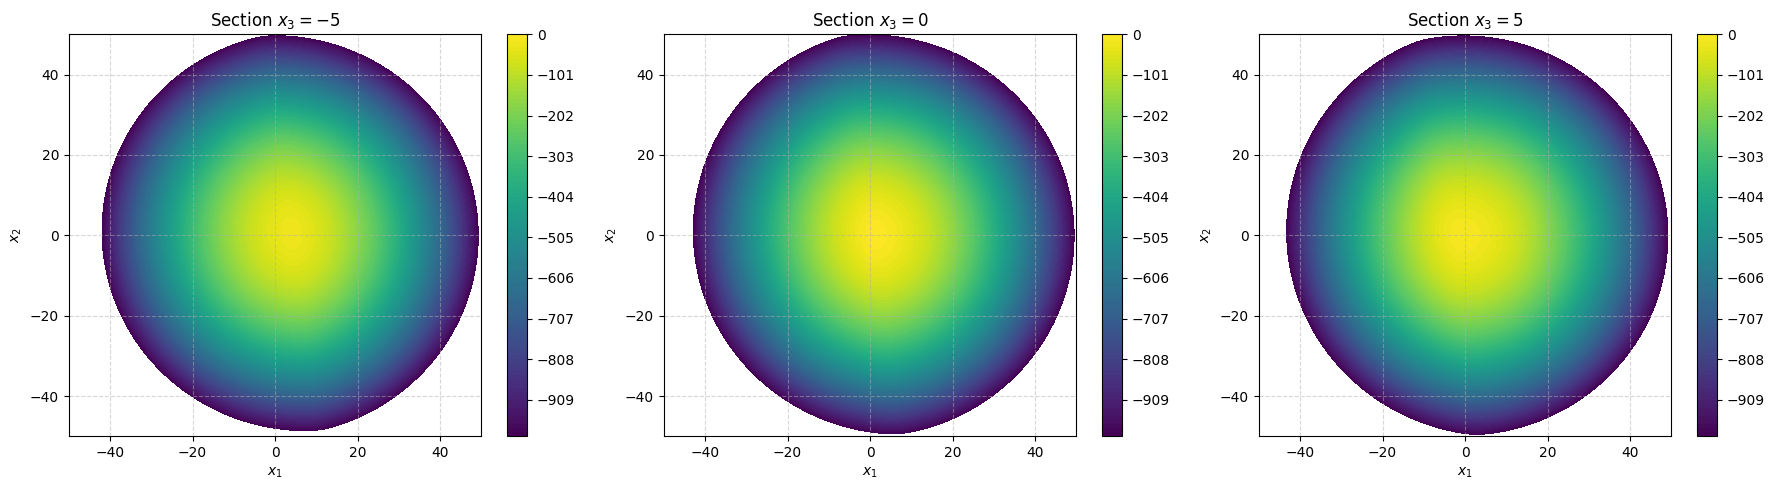

In [268]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# --- Génération de données en dimension 3 ---
X, Y = make_classification(
    n_samples=10, n_features=3, n_classes=2,
    random_state=0, n_informative=1, n_redundant=2, n_clusters_per_class=1
)
Y = 2 * Y - 1  # transforme 0/1 en -1/1

# --- Définition de la log-vraisemblance BLR ---
def log_likelihood_blr(x, X, Y, e):
    z = Y * (X @ x)
    return -np.sum(np.log1p(np.exp(-z))) - (e / 2) * np.sum(x**2)

# --- Grille 2D ---
grid = np.linspace(-50, 50, 200)
Xg, Yg = np.meshgrid(grid, grid)
e = 0.8

# --- Définir les niveaux entre -1000 et 0 ---
levels = np.linspace(-1000, 0, 100)

# --- Tracé des coupes 2D pour x3 = -5, 0, 5 ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, x3 in enumerate([-5, 0, 5]):
    Vals = np.zeros_like(Xg)
    for i in range(Xg.shape[0]):
        for j in range(Xg.shape[1]):
            x_vec = np.array([Xg[i, j], Yg[i, j], x3])
            Vals[i, j] = log_likelihood_blr(x_vec, X, Y, e)

    cs = axes[idx].contourf(Xg, Yg, Vals, levels=levels, cmap="viridis", vmin=-1000, vmax=0)
    axes[idx].set_title(f"Section $x_3={x3}$")
    axes[idx].set_xlabel("$x_1$")
    axes[idx].set_ylabel("$x_2$")
    fig.colorbar(cs, ax=axes[idx])
    
    # Activer la grille pour chaque axe
    axes[idx].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("images/section_informative.png", dpi=300, bbox_inches='tight')
plt.show()


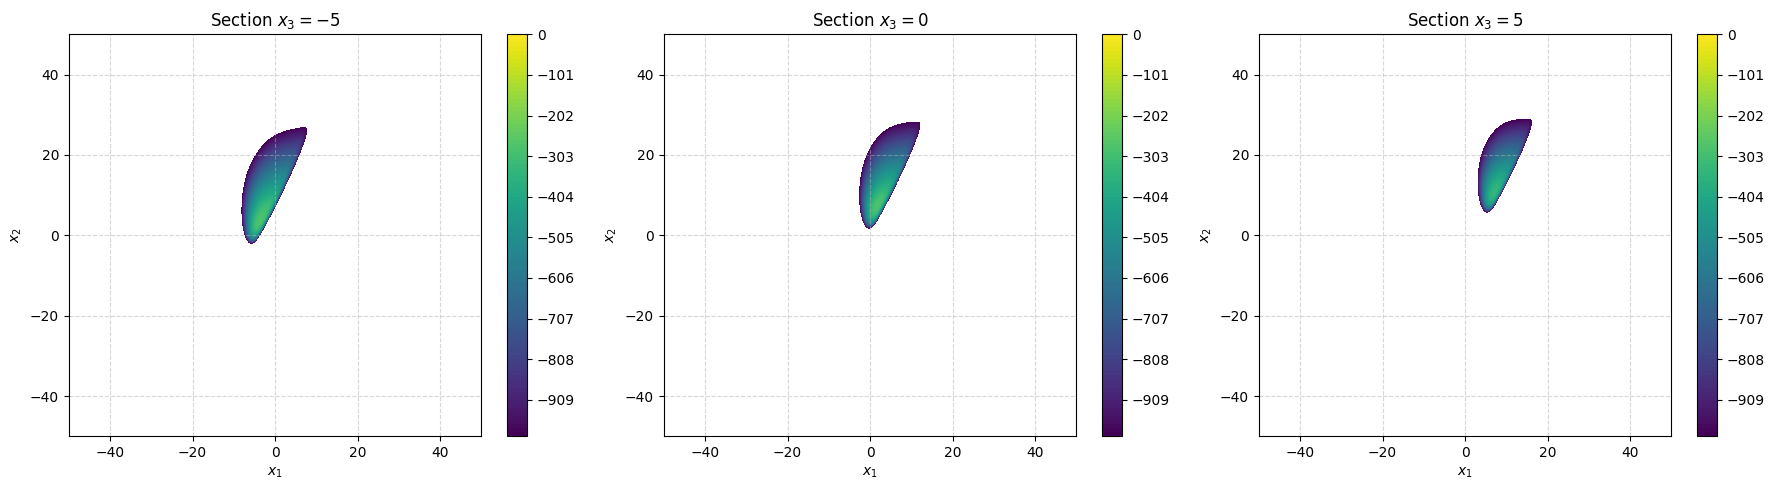

In [269]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# --- Génération de données en dimension 3 ---
X, Y = make_classification(
    n_samples=5000, n_features=3, n_classes=2,
    random_state=0, n_informative=2, n_redundant=1, n_clusters_per_class=1
)
Y = 2 * Y - 1  # transforme 0/1 en -1/1

# --- Définition de la log-vraisemblance BLR ---
def log_likelihood_blr(x, X, Y, e):
    z = Y * (X @ x)
    return -np.sum(np.log1p(np.exp(-z))) - (e / 2) * np.sum(x**2)

# --- Grille 2D ---
grid = np.linspace(-50, 50, 200)
Xg, Yg = np.meshgrid(grid, grid)
e = 0.8

# --- Définir les niveaux entre -1000 et 0 ---
levels = np.linspace(-1000, 0, 100)

# --- Tracé des coupes 2D pour x3 = -5, 0, 5 ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, x3 in enumerate([-5, 0, 5]):
    Vals = np.zeros_like(Xg)
    for i in range(Xg.shape[0]):
        for j in range(Xg.shape[1]):
            x_vec = np.array([Xg[i, j], Yg[i, j], x3])
            Vals[i, j] = log_likelihood_blr(x_vec, X, Y, e)

    cs = axes[idx].contourf(Xg, Yg, Vals, levels=levels, cmap="viridis", vmin=-1000, vmax=0)
    axes[idx].set_title(f"Section $x_3={x3}$")
    axes[idx].set_xlabel("$x_1$")
    axes[idx].set_ylabel("$x_2$")
    fig.colorbar(cs, ax=axes[idx])
    
    # Activer la grille pour chaque axe
    axes[idx].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("images/section_informative.png", dpi=300, bbox_inches='tight')
plt.show()


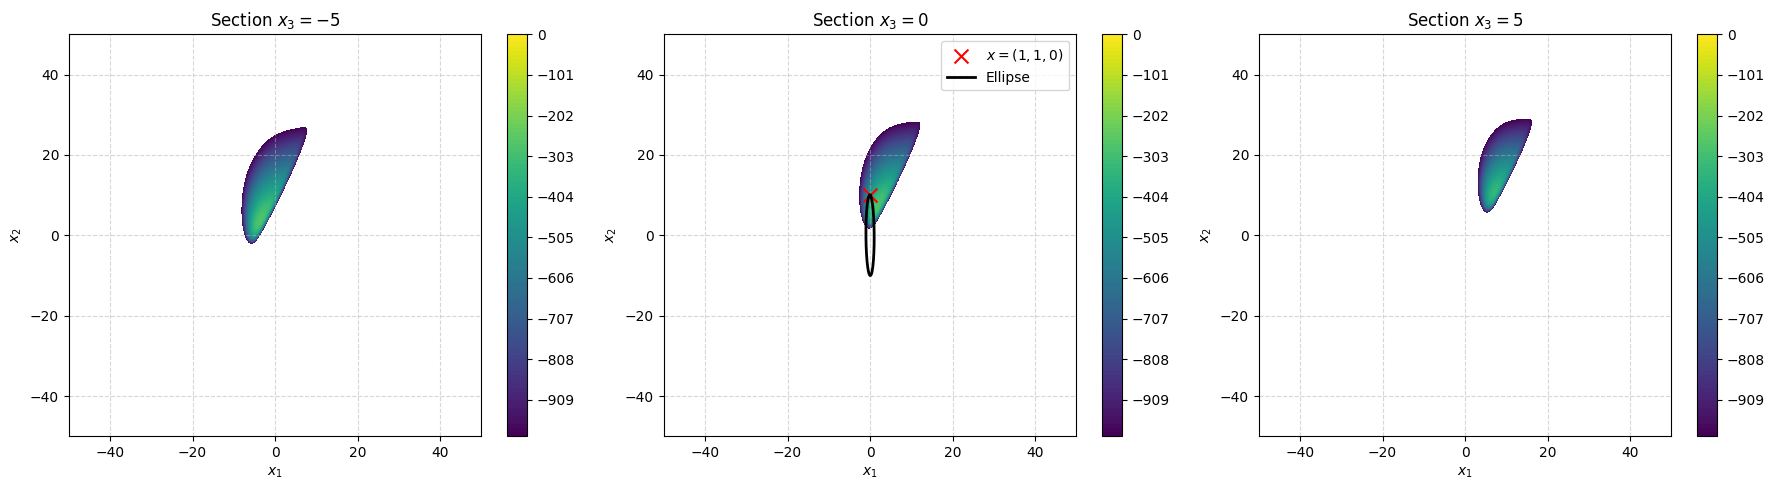

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from matplotlib.lines import Line2D

# --- Génération de données en dimension 3 ---
X, Y = make_classification(
    n_samples=5000, n_features=3, n_classes=2,
    random_state=0, n_informative=2, n_redundant=1, n_clusters_per_class=1
)
Y = 2 * Y - 1  # transforme 0/1 en -1/1

# --- Définition de la log-vraisemblance BLR ---
def log_likelihood_blr(x, X, Y, e):
    z = Y * (X @ x)
    return -np.sum(np.log1p(np.exp(-z))) - (e / 2) * np.sum(x**2)

# --- Grille 2D ---
grid = np.linspace(-50, 50, 200)
Xg, Yg = np.meshgrid(grid, grid)
e = 0.8

# --- Définir les niveaux entre -1000 et 0 ---
levels = np.linspace(-1000, 0, 100)

# --- Point et ellipse pour x3 = 0 ---
x0 = np.array([0.0, 10.0, 0.0])
w = np.array([np.random.randn(), np.random.randn(), 0.0])
theta = np.linspace(0, 2*np.pi, 400)
ellipse = np.outer(np.cos(theta), x0) + np.outer(np.sin(theta), w)

# --- Tracé des coupes 2D pour x3 = -5, 0, 5 ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, x3 in enumerate([-5, 0, 5]):
    Vals = np.zeros_like(Xg)
    for i in range(Xg.shape[0]):
        for j in range(Xg.shape[1]):
            x_vec = np.array([Xg[i, j], Yg[i, j], x3])
            Vals[i, j] = log_likelihood_blr(x_vec, X, Y, e)

    # Contours remplis
    cs = axes[idx].contourf(Xg, Yg, Vals, levels=levels, cmap="viridis", vmin=-1000, vmax=0)
    fig.colorbar(cs, ax=axes[idx])

    # Grille
    axes[idx].grid(True, linestyle='--', alpha=0.5)

    # Ajouter le point et l'ellipse uniquement pour x3 = 0
    if x3 == 0:
        axes[idx].scatter(x0[0], x0[1], c="red", marker="x", s=100, label="$x=(1,1,0)$")
        axes[idx].plot(ellipse[:,0], ellipse[:,1], c="black", lw=2, label="Ellipse")
        axes[idx].legend()

    # Titres et labels
    axes[idx].set_title(f"Section $x_3={x3}$")
    axes[idx].set_xlabel("$x_1$")
    axes[idx].set_ylabel("$x_2$")

plt.tight_layout()
plt.savefig("images/section_informative.png", dpi=300, bbox_inches='tight')
plt.show()


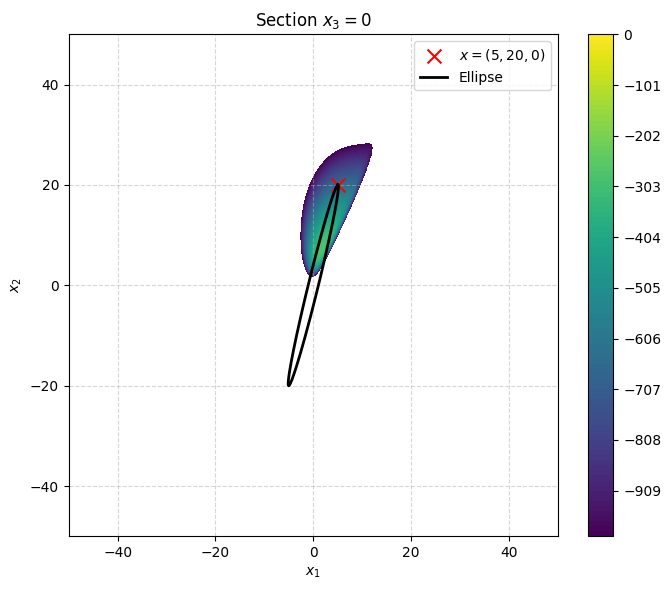

In [290]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# --- Génération de données en dimension 3 ---
X, Y = make_classification(
    n_samples=5000, n_features=3, n_classes=2,
    random_state=0, n_informative=2, n_redundant=1, n_clusters_per_class=1
)
Y = 2 * Y - 1  # transforme 0/1 en -1/1

# --- Définition de la log-vraisemblance BLR ---
def log_likelihood_blr(x, X, Y, e):
    z = Y * (X @ x)
    return -np.sum(np.log1p(np.exp(-z))) - (e / 2) * np.sum(x**2)

# --- Grille 2D ---
grid = np.linspace(-50, 50, 200)
Xg, Yg = np.meshgrid(grid, grid)
e = 0.8

# --- Définir les niveaux entre -1000 et 0 ---
levels = np.linspace(-1000, 0, 100)

# --- Point et ellipse pour x3 = 0 ---
x0 = np.array([5.0, 20.0, 0.0])
w = np.array([np.random.randn(), np.random.randn(), 0.0])
theta = np.linspace(0, 2*np.pi, 400)
ellipse = np.outer(np.cos(theta), x0) + np.outer(np.sin(theta), w)

# --- Calcul des valeurs pour x3 = 0 ---
Vals = np.zeros_like(Xg)
for i in range(Xg.shape[0]):
    for j in range(Xg.shape[1]):
        x_vec = np.array([Xg[i, j], Yg[i, j], 0])
        Vals[i, j] = log_likelihood_blr(x_vec, X, Y, e)

# --- Tracé ---
fig, ax = plt.subplots(figsize=(7, 6))
cs = ax.contourf(Xg, Yg, Vals, levels=levels, cmap="viridis", vmin=-1000, vmax=0)
fig.colorbar(cs, ax=ax)

# Grille
ax.grid(True, linestyle='--', alpha=0.5)

# Point et ellipse
ax.scatter(x0[0], x0[1], c="red", marker="x", s=100, label="$x=(5,20,0)$")
ax.plot(ellipse[:, 0], ellipse[:, 1], c="black", lw=2, label="Ellipse")
ax.legend()

# Titres et labels
ax.set_title("Section $x_3=0$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.tight_layout()
plt.savefig("images/section_inf.png", dpi=300, bbox_inches='tight')
plt.show()


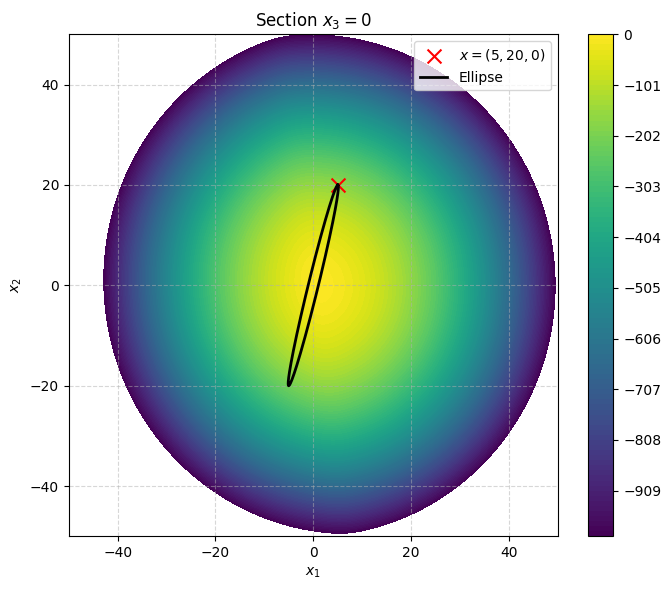

In [291]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# --- Génération de données en dimension 3 ---
X, Y = make_classification(
    n_samples=10, n_features=3, n_classes=2,
    random_state=0, n_informative=1, n_redundant=2, n_clusters_per_class=1
)
Y = 2 * Y - 1  # transforme 0/1 en -1/1

# --- Définition de la log-vraisemblance BLR ---
def log_likelihood_blr(x, X, Y, e):
    z = Y * (X @ x)
    return -np.sum(np.log1p(np.exp(-z))) - (e / 2) * np.sum(x**2)

# --- Grille 2D ---
grid = np.linspace(-50, 50, 200)
Xg, Yg = np.meshgrid(grid, grid)
e = 0.8

# --- Définir les niveaux entre -1000 et 0 ---
levels = np.linspace(-1000, 0, 100)

# --- Point et ellipse pour x3 = 0 ---
x0 = np.array([5.0, 20.0, 0.0])
theta = np.linspace(0, 2*np.pi, 400)
ellipse = np.outer(np.cos(theta), x0) + np.outer(np.sin(theta), w)

# --- Calcul des valeurs pour x3 = 0 ---
Vals = np.zeros_like(Xg)
for i in range(Xg.shape[0]):
    for j in range(Xg.shape[1]):
        x_vec = np.array([Xg[i, j], Yg[i, j], 0])
        Vals[i, j] = log_likelihood_blr(x_vec, X, Y, e)

# --- Tracé ---
fig, ax = plt.subplots(figsize=(7, 6))
cs = ax.contourf(Xg, Yg, Vals, levels=levels, cmap="viridis", vmin=-1000, vmax=0)
fig.colorbar(cs, ax=ax)

# Grille
ax.grid(True, linestyle='--', alpha=0.5)

# Point et ellipse
ax.scatter(x0[0], x0[1], c="red", marker="x", s=100, label="$x=(5,20,0)$")
ax.plot(ellipse[:, 0], ellipse[:, 1], c="black", lw=2, label="Ellipse")
ax.legend()

# Titres et labels
ax.set_title("Section $x_3=0$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.tight_layout()
plt.savefig("images/section_non_inf.png", dpi=300, bbox_inches='tight')
plt.show()


### Transition sampling E(x, dy)

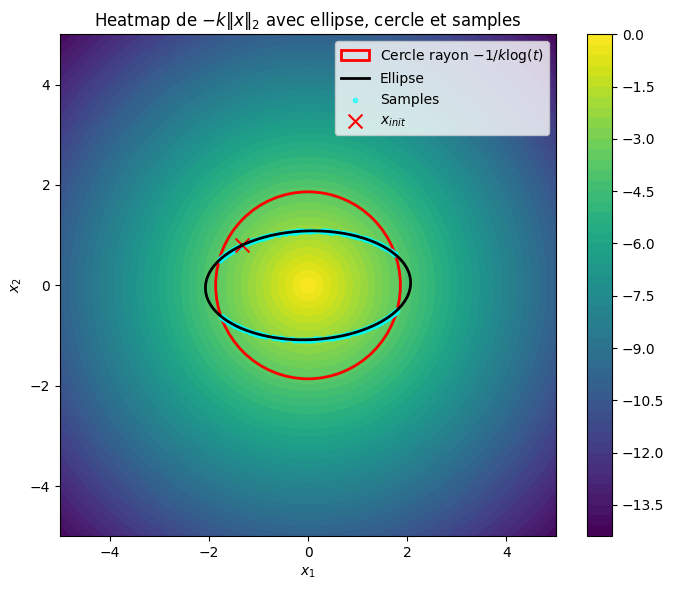

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- Fonction de vraisemblance exponentielle ---
def exp_likelihood(k, x):
    return -k * np.sqrt(np.sum(x**2))

def exp_transition(x, w, log_t, k):
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    proposal = x * np.cos(theta) + w * np.sin(theta)
    while exp_likelihood(k, proposal) < log_t:
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal = x * np.cos(theta) + w * np.sin(theta)
    return proposal, theta

def ess_exp(x_init, k, N):
    sample = []
    valid_theta = []
    w = np.random.randn(2)
    log_t = np.log(np.random.uniform(0, 1)) + exp_likelihood(k, x_init)
    for _ in range(N):
        proposal, theta = exp_transition(x_init, w, log_t, k)
        sample.append(proposal)
        valid_theta.append(theta)
    return np.array(sample), np.array(valid_theta), log_t, w

# --- Script principal ---
if __name__ == "__main__":
    x_init = np.random.randn(2)
    N = 500
    k = 2

    # Échantillonnage
    sample, theta, log_t, w = ess_exp(x_init, k, N)

    # Rayon du cercle
    r = -1 / k * log_t

    # Grille pour heatmap
    grid = np.linspace(-5, 5, 200)
    Xg, Yg = np.meshgrid(grid, grid)
    Z = np.zeros_like(Xg)
    for i in range(Xg.shape[0]):
        for j in range(Xg.shape[1]):
            Z[i, j] = exp_likelihood(k, np.array([Xg[i, j], Yg[i, j]]))

    # Tracé heatmap
    fig, ax = plt.subplots(figsize=(7, 6))
    cs = ax.contourf(Xg, Yg, Z, levels=50, cmap="viridis")
    fig.colorbar(cs, ax=ax)

    # Cercle
    circle = plt.Circle((0, 0), r, color="red", fill=False, linewidth=2, label="Cercle rayon $-1/k \\log(t)$")
    ax.add_patch(circle)

    # Ellipse
    thetas = np.linspace(0, 2*np.pi, 400)
    ellipse = np.outer(np.cos(thetas), x_init) + np.outer(np.sin(thetas), w)
    ax.plot(ellipse[:, 0], ellipse[:, 1], c="black", lw=2, label="Ellipse")

    # Points échantillonnés
    ax.scatter(sample[:, 0], sample[:, 1], c="cyan", s=10, alpha=0.6, label="Samples")

    # Point initial
    ax.scatter(x_init[0], x_init[1], c="red", marker="x", s=100, label="$x_{init}$")

    # Mise en forme
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title("Heatmap de $-k \\|x\\|_2$ avec ellipse, cercle et samples")
    ax.legend()

    plt.tight_layout()
    plt.savefig("images/exp_likelihood_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()


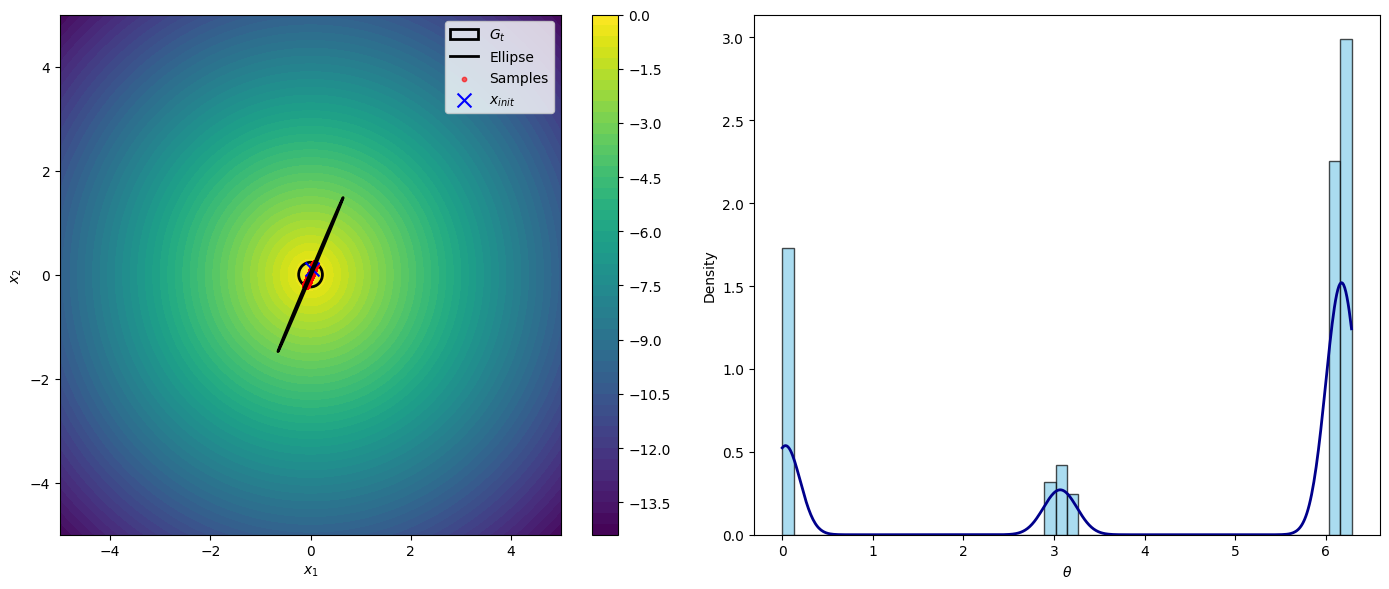

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Fonction de vraisemblance exponentielle ---
def exp_likelihood(k, x):
    return -k * np.sqrt(np.sum(x**2))

def exp_transition(x, w, log_t, k):
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    proposal = x * np.cos(theta) + w * np.sin(theta)
    while exp_likelihood(k, proposal) < log_t:
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal = x * np.cos(theta) + w * np.sin(theta)
    return proposal, theta

def ess_exp(x_init, k, N):
    sample = []
    valid_theta = []
    w = np.random.randn(2)
    log_t = np.log(np.random.uniform(0, 1)) + exp_likelihood(k, x_init)
    for _ in range(N):
        proposal, theta = exp_transition(x_init, w, log_t, k)
        sample.append(proposal)
        valid_theta.append(theta)
    return np.array(sample), np.array(valid_theta), log_t, w

# --- Script principal ---
if __name__ == "__main__":
    x_init = np.random.randn(2)
    N = 10**6
    k = 2

    # Échantillonnage
    sample, thetas, log_t, w = ess_exp(x_init, k, N)

    # Rayon du cercle
    r = -1 / k * log_t

    # Grille pour heatmap
    grid = np.linspace(-5, 5, 200)
    Xg, Yg = np.meshgrid(grid, grid)
    Z = np.zeros_like(Xg)
    for i in range(Xg.shape[0]):
        for j in range(Xg.shape[1]):
            Z[i, j] = exp_likelihood(k, np.array([Xg[i, j], Yg[i, j]]))

    # Figure avec 2 sous-graphiques : heatmap + histogramme des thetas
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Heatmap ---
    cs = axes[0].contourf(Xg, Yg, Z, levels=50, cmap="viridis")
    fig.colorbar(cs, ax=axes[0])

    # Cercle
    circle = plt.Circle((0, 0), r, color="black", fill=False, linewidth=2, label="$G_t$")
    axes[0].add_patch(circle)

    # Ellipse
    phi = np.linspace(0, 2*np.pi, 400)
    ellipse = np.outer(np.cos(phi), x_init) + np.outer(np.sin(phi), w)
    axes[0].plot(ellipse[:, 0], ellipse[:, 1], c="black", lw=2, label="Ellipse")

    # Points échantillonnés
    axes[0].scatter(sample[:, 0], sample[:, 1], c="red", s=10, alpha=0.6, label="Samples")

    # Point initial
    axes[0].scatter(x_init[0], x_init[1], c="blue", marker="x", s=100, label="$x_{init}$")

    axes[0].set_xlabel("$x_1$")
    axes[0].set_ylabel("$x_2$")
    #axes[0].set_title("Heatmap of $-k \\|x\\|_2$")
    axes[0].legend()

    # --- Histogramme des thetas ---
    thetas_mod = np.mod(thetas, 2*np.pi)
    axes[1].hist(thetas_mod, bins=50, density=True, color="skyblue", edgecolor="k", alpha=0.7)
    kde = gaussian_kde(thetas_mod)
    theta_grid = np.linspace(0, 2*np.pi, 500)
    axes[1].plot(theta_grid, kde(theta_grid), color="darkblue", lw=2, label="KDE")

    axes[1].set_xlabel(r"$\theta$")
    axes[1].set_ylabel("Density")
    #axes[1].set_title("Distribution empirique des angles $\\theta$")

    plt.tight_layout()
    plt.savefig("images/theta_distrib.png", dpi=300, bbox_inches="tight")
    plt.show()